# Predict the strength of concrete

## 📖 Background

Concrete is the most widely used building material in the world. It is a mix of cement and water with gravel and sand. It can also include other materials like fly ash, blast furnace slag, and additives. 

The compressive strength of concrete is a function of components and age, the team is testing different combinations of ingredients at different time intervals. 

Find a simple way to estimate strength to predict how a particular sample is expected to perform.

The objective is to answer:
1. The average strength of the concrete samples at 1, 7, 14, and 28 days of age.
2. The coefficients of regression model using the formula that provided us:
![Strength Equation](str_eq.png)

## 💾 The data
The team has already tested more than a thousand samples ([source](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength)):

#### Compressive strength data:
- "cement" - Portland cement in kg/m3
- "slag" - Blast furnace slag in kg/m3
- "fly_ash" - Fly ash in kg/m3
- "water" - Water in liters/m3
- "superplasticizer" - Superplasticizer additive in kg/m3
- "coarse_aggregate" - Coarse aggregate (gravel) in kg/m3
- "fine_aggregate" - Fine aggregate (sand) in kg/m3
- "age" - Age of the sample in days
- "strength" - Concrete compressive strength in megapascals (MPa)

***Acknowledgments**: I-Cheng Yeh, "Modeling of strength of high-performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998)*.

## Import Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [27]:
df = pd.read_csv('data/concrete_data.csv')
df.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


## Data Preprocessing

### Data Size and Structure

- Dataset comprises of 1030 observations.
- 8 features and 1 target variable `strength`.
- All columns are numerical
- No null values

In [28]:
print(f'Shape: {df.shape} \n')
df.info()

Shape: (1030, 9) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   fly_ash           1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarse_aggregate  1030 non-null   float64
 6   fine_aggregate    1030 non-null   float64
 7   age               1030 non-null   int64  
 8   strength          1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


### Duplicated Data
A small 2.43% of the dataset are duplicated. I decided to drop these, so now the dataset has 1005 observations.

In [29]:
dup_perc = df.duplicated().sum() / len(df) * 100
print(f'Duplicated percentage: {np.round(dup_perc, 2)}%')
df.drop_duplicates(inplace=True)
print(f'df shape after removing duplicates: {df.shape}')

Duplicated percentage: 2.43%
df shape after removing duplicates: (1005, 9)


### Outliers

Boxplots show that there are outliers in our data, but not many.
We will be replacing these outliers with their median.

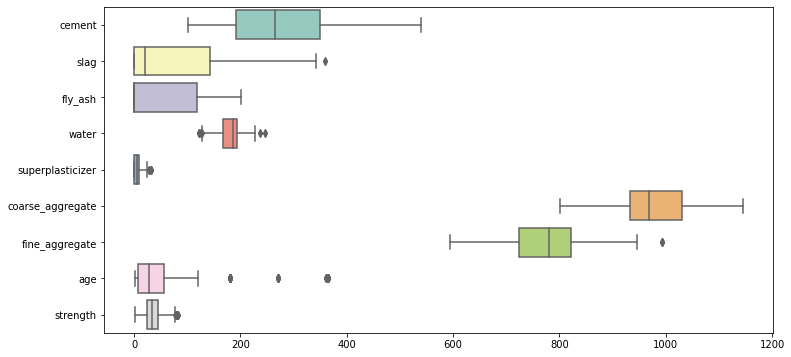

In [30]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, orient="h", palette="Set3")
plt.show()

In [31]:
for col_name in df.columns[:-1]:
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    df.loc[(df[col_name] < low) | (df[col_name] > high), col_name] = df[col_name].median()

### Summary Statistics

Variance, skew, and kurtosis is also included. <br>
We can see that all variables have skew are in asymmetric form.

In [32]:
desc = df.describe().T
desc['var'] = df.var(axis=0)
desc['skew'] = df.skew(axis=0)
desc['kurtosis'] = df.kurtosis(axis=0)
desc

,count,mean,std,min,25%,50%,75%,max,var,skew,kurtosis
cement,1005.0,278.629055,104.345003,102.000000,190.680000,265.000000,349.00000,540.000000,10887.879601,0.564997,-0.432463
slag,1005.0,71.367711,85.239740,0.000000,0.000000,20.000000,141.30000,342.100000,7265.813343,0.830465,-0.524116
fly_ash,1005.0,55.535075,64.207448,0.000000,0.000000,0.000000,118.27000,200.100000,4122.596436,0.497324,-1.366457
water,1005.0,182.521294,20.114500,127.300000,168.000000,185.700000,192.00000,228.000000,404.593097,0.126521,-0.076357
superplasticizer,1005.0,5.791846,5.396851,0.000000,0.000000,6.100000,9.90000,23.400000,29.126001,0.514240,-0.312220
coarse_aggregate,1005.0,974.376468,77.579534,801.000000,932.000000,968.000000,1031.00000,1145.000000,6018.584052,-0.065242,-0.583034
fine_aggregate,1005.0,771.628905,78.821267,594.000000,724.300000,780.000000,822.00000,945.000000,6212.792066,-0.335220,-0.198316
age,1005.0,32.117413,27.665333,1.000000,7.000000,28.000000,28.00000,120.000000,765.370663,1.312008,0.876534
strength,1005.0,35.250273,16.284808,2.331808,23.523542,33.798114,44.86834,82.599225,265.194960,0.395653,-0.305402


## Exploratory Data Analysis

### Correlation matrix

Let's look at the relationship between all the variables and their correlation. <br>
From the heatmap, we observe target variable `strength` has a high positive correlation `cement` 0.49, `superplasticizer` 0.32, and `age` 0.5. <br>
There is a strong negative correlation (-0.61) between `superplasticizer` and `water`.

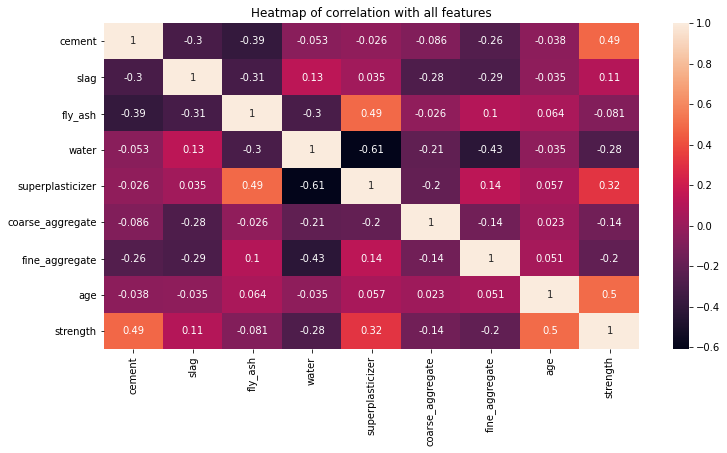

In [33]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True)
plt.title('Heatmap of correlation with all features')
plt.show()

### Age

Age is a very important characteristic that affects concrete strength.

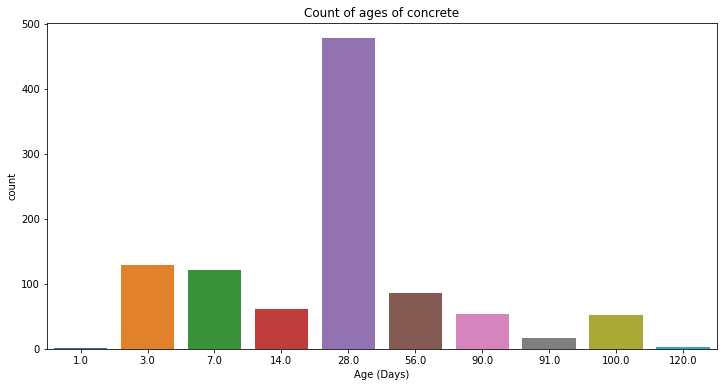

In [34]:
plt.figure(figsize=(12,6))
sns.countplot(x='age', data=df)
plt.title(label="Count of ages of concrete")
plt.xlabel("Age (Days)")
plt.show()

This bar plot shows that age is a categorical variable with a high number of observations at 28 days. <br>
The 28 days time frame is significant because this is the period for concrete to reach 99% of it's strength. While the concrete continuous to gain strength after that period, the rate of gain is much less compared to that in 28 days.

In [35]:
avg_str_by_day = df.groupby('age').agg(['mean', 'count'])['strength']
avg_str_by_day.reset_index(inplace=True)
avg_str_by_day.age = avg_str_by_day.age.astype(int)
avg_str_by_day = avg_str_by_day.style.set_caption("Average concrete strength at different ages (Days):")
print(f'Average concrete strength: {df.strength.mean()} \n')
avg_str_by_day

Average concrete strength: 35.25027287623584 



,age,mean,count
0,1,9.452716,2
1,3,18.378023,129
2,7,25.181843,122
3,14,28.751038,62
4,28,37.383788,478
5,56,50.715152,86
6,90,40.480809,54
7,91,68.674649,17
8,100,47.668780,52
9,120,39.647168,3


From the table we can see that average concrete strength at 28 days is similar to the average strength of the entire dataset.

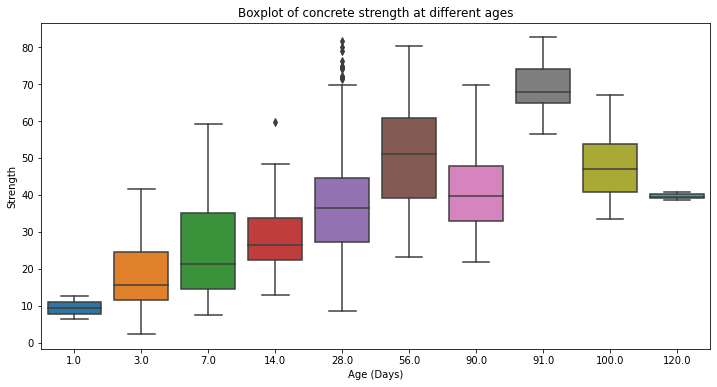

In [36]:
plt.figure(figsize=(12,6))
sns.boxplot(x='age', y='strength', data=df);
plt.title(label="Boxplot of concrete strength at different ages")   
plt.xlabel("Age (Days)")
plt.ylabel("Strength")
plt.show()

In this boxplot, concrete strength is the highest at 91 days. They have the highest median strenght with a narrow variation. We can also see that strength has the largest variation at 28 days.

##  1. Average strength of the concrete samples at 1, 7, 14, and 28 days of age.

Average strength of concrete is the lowest after 1 day and increases significantly after 7 days. Strength continues to increase in MPa after 14 and 28 days.

In [37]:
ages = [1, 7, 14, 28]

for age in ages:
    cond = df.age == age
    avg_str = df[cond].strength.mean().round(2)
    if age == 1:
        print(f'Average strength of the concrete sample is {avg_str} MPa at {age} day.')
    else:
        print(f'Average strength of the concrete sample is {avg_str} MPa at {age} days.')

Average strength of the concrete sample is 9.45 MPa at 1 day.
Average strength of the concrete sample is 25.18 MPa at 7 days.
Average strength of the concrete sample is 28.75 MPa at 14 days.
Average strength of the concrete sample is 37.38 MPa at 28 days.


## 2. Creating predictive model

Now let's help our colleages in the engineering department find out the coefficients $\beta_{0}$, $\beta_{1}$ ... $\beta_{8}$, to use in the following formula:

![Strength Equation](str_eq.png)

## Train Test Split

Split the data to train (80%) and test (20%) to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

In [38]:
features = ['cement', 'slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age']
X = df[features] # Features
y = df['strength'] # Target

In [39]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

print('X train data {}'.format(X_train.shape))
print('y train data {}'.format(y_train.shape))
print('X test data  {}'.format(X_test.shape))
print('y test data  {}'.format(y_test.shape))

X train data (804, 8)
y train data (804,)
X test data  (201, 8)
y test data  (201,)


### Encoding age

We observed that `age` is a variabel comprised of a finite set of discrete values with a ranked ordering between values.

In [16]:
def ordinal_encoding_feature(data, feature):    
    '''Transform selected column with ordinal encoder
    
    INPUTS:
    data: dataframe
    feature: column name
    
    OUTPUT:
    d: dataframe with feature ordinally encoded
    '''  
    d = data.copy()
    encoder = OrdinalEncoder()
    # Reshape because only one column is transformed
    encoder.fit(data[feature].values.reshape(-1,1))
    d[feature]= encoder.transform(data.age.values.reshape(-1,1))
    return d
X_train = X_train.pipe(ordinal_encoding_feature, 'age')
X_test = X_test.pipe(ordinal_encoding_feature, 'age')

## Model Selection

We will be using a supervised regression model since the target variable `strength` is labeled and continuous. <br>
Using k-folds cross validation to estimate and compare the performance of models on out-of-sample data using r2 score. This enables us to identify which model is worth improving upon. <br>
GradientBoostRegressor gives the best results out of models, with the highest r2score of 0.89.

In [47]:
pipelines = []
pipelines.append(('Linear Regression', Pipeline([('scaler', StandardScaler()), ('LR', LinearRegression())])))
pipelines.append(('KNN Regressor', Pipeline([('scaler', StandardScaler()), ('KNNR', KNeighborsRegressor())])))
pipelines.append(('SupportVectorRegressor', Pipeline([('scaler', StandardScaler()), ('SVR', SVR())])))
pipelines.append(('DecisionTreeRegressor', Pipeline([('scaler', StandardScaler()), ('DTR', DecisionTreeRegressor())])))
pipelines.append(('AdaboostRegressor', Pipeline([('scaler', StandardScaler()), ('ABR', AdaBoostRegressor())])))
pipelines.append(('RandomForestRegressor', Pipeline([('scaler', StandardScaler()), ('RBR', RandomForestRegressor())])))
pipelines.append(('BaggingRegressor', Pipeline([('scaler', StandardScaler()), ('BGR', BaggingRegressor())])))
pipelines.append(('GradientBoostRegressor', Pipeline([('scaler', StandardScaler()), ('GBR', GradientBoostingRegressor())])))

In [48]:
# Create empty dataframe to store the results
cv_scores = pd.DataFrame({'Regressor':[], 'R2':[], 'Std':[]})

# Cross-validation score for each pipeline for training data
for ind, val in enumerate(pipelines):
    name, pipeline = val
    kfold = KFold(n_splits=5) 
    score = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring="r2")
    cv_scores.loc[ind] = [name, score.mean(), score.std()]
cv_scores

,Regressor,R2,Std
0,Linear Regression,0.692789,0.024918
1,KNN Regressor,0.734288,0.011374
2,SupportVectorRegressor,0.653195,0.016694
3,DecisionTreeRegressor,0.809446,0.017700
4,AdaboostRegressor,0.767163,0.018195
5,RandomForestRegressor,0.881392,0.012559
6,BaggingRegressor,0.871171,0.022079
7,GradientBoostRegressor,0.885697,0.011570


## Model Tuning

Using Grid Search to tune hyperparameters of Gradient Boosting Regressor.

In [55]:
steps = [('scaler', StandardScaler()), ('GBR', GradientBoostingRegressor())]
pipeline = Pipeline(steps)

param_grid=[{'GBR__n_estimators':[100,500,1000], 
             'GBR__learning_rate': [0.1,0.05,0.02,0.01], 
             'GBR__max_depth':[4,6], 
             'GBR__min_samples_leaf':[3,5,9,17], 
             'GBR__max_features':[1.0,0.3,0.1] }]

search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2', n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
print(search.best_estimator_) 
print("R Squared:", search.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Pipeline(steps=[('GBR',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                           max_features=0.3,
                                           min_samples_leaf=17,
                                           n_estimators=1000))])
R Squared: 0.9250513959645825


Now that we have identified the best model, let's use it to predict on our unseen data `X_test`.

In [68]:
best_model = search.best_estimator_

es = EarlyStopping(monitor = 'val_loss', mode='min',patience=5, verbose=1)
best_model.fit(X_train, y_train)

Pipeline(steps=[('GBR',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                           max_features=0.3,
                                           min_samples_leaf=17,
                                           n_estimators=1000))])

In [65]:
y_pred = best_model.predict(X_test)

## Model Evaluation

Let's evaluate the model's performance on the testing data to assess the likely future performance of a model.


In [66]:
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}')
print(f'Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred)**0.5}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

Mean Absolute Error (MAE): 2.857554474106023
Mean Squared Error (MSE): 18.697809837585048
RMSE: 4.324096418627255
R2 Score: 0.9270673834665101


## Feature Importance

Using the feature importance of the model, we get the coefficients $\beta_{0}$, $\beta_{1}$ ... $\beta_{8}$, to use in the following formula:
![Strength Equation](str_eq.png)

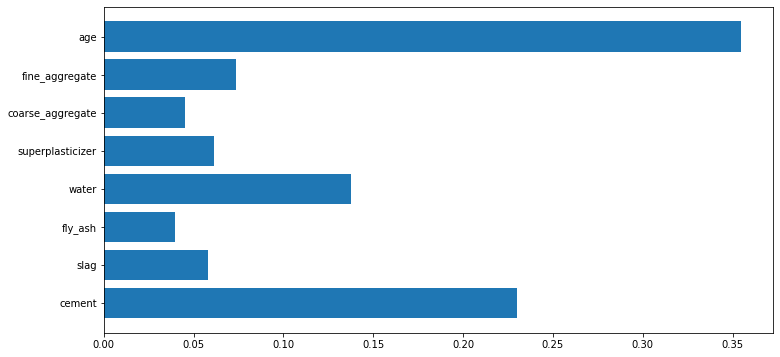

In [70]:
betas = best_model[1].feature_importances_
plt.figure(figsize=(12,6))
plt.barh(features, betas)
plt.show()

In [71]:
betas_dict = dict(zip(features, betas))
beta_0 = np.mean(y - np.sum(X*betas, axis=1))
print(f"Concrete Strength = {beta_0} +")
for key in betas_dict.keys():
    if key == "age":
        print(f"{betas_dict[key]} * {key}")
    else:
        print(f"{betas_dict[key]} * {key} +")

Concrete Strength = -172.73850453322098 +
0.2298719580731237 * cement +
0.05785238568150824 * slag +
0.03957066757451669 * fly_ash +
0.1375242032644161 * water +
0.06154927686809351 * superplasticizer +
0.04513983123823491 * coarse_aggregate +
0.0735764168446555 * fine_aggregate +
0.35491526045545135 * age
